# Funcione básicas métricas xAI

En este notebook se va a desarrollar las funciones auxiliares necesarias para poder hacer las medidas de Precision y Recall.

In [8]:
import pandas as pd
import numpy as np

import src.latent_factor_xai as lfxai

# Función common_attr
Esta función devuelve los atributos que comparten al menos un atributo.

INPUT:

- id_movie1: identificador de la película 1
- id_movie2: identificador de la película 2

RETURN:

array con el nombre de los atributos en común.

CONSIDERACIONES:

- Estrellas y géneros se considerará en común si al menos ambas películas comparten uno de los valores.
- Duración se considera común si la diferencia es menor a 25 minutos.
- El resto de atributos se considerarán comunes si tienen el mismo valor.

In [37]:
def get_common_attr(movies_df, id_movie1, id_movie2):
    movie1 = movies_df[movies_df['id'] == id_movie1]
    movie2 = movies_df[movies_df['id'] == id_movie2]

    if len(movie1['id']) == 0 or len(movie2['id']) == 0:
        return []

    common_attr = []

    for col in movie1.columns.values:
        if col == 'duration':
            if (abs(movie1['duration'].values[0] - movie2['duration'].values[0]) < 25):
                common_attr.append(col)

        elif col == 'genres' or col == 'stars':
            set_m1 = set(movie1[col].values[0].split('|'))
            set_m2 = set(movie2[col].values[0].split('|'))

            if len(set_m1 & set_m2) > 0:
                common_attr.append(col)

        elif col != 'id' and col != 'movie_title':
            if movie1[col].values[0] == movie2[col].values[0]:
                common_attr.append(col)

    return common_attr

In [38]:
# Prueba 1: Atributos en común

# Cargamos los datos
trainset = pd.read_csv('data/experiment_data/trainset.csv')
testset = pd.read_csv('data/experiment_data/testset.csv')
movies_df = pd.read_csv('data/experiment_data/movies.csv')

In [39]:
# Creamos y entrenamos el modelo
model = lfxai.NMF_XAI()
model.fit(trainset, movies_df)

In [59]:
# Recorremos los valores de test y vemos cuantos ejemplos devuelven y cuantos atributos se explican

num_exceptions = 0
tests_results = []
test_id = 0

for tst in testset.values:
    test_id += 1
    try:
        pred = model.predict(int(tst[0]), int(tst[1]))
        examples = model.get_examples(int(tst[0]), int(tst[1]))
        
        common_attr = []
        for ex in examples:
            common_attr.extend(get_common_attr(movies_df, int(tst[1]), ex))
        
        tests_results.append([test_id, int(tst[0]), int(tst[1]), pred, tst[2], len(examples), str(set(common_attr))])
        
        #print("uid:{} -- iid:{} -- pred:{} -- real:{} -- examples:{} -- attrs:{}".format(int(tst[0]), int(tst[1]), pred, tst[2], len(examples), set(common_attr)))
    except Exception as e:
        num_exceptions += 1
        pass
    
print("Exceptions: {}".format(num_exceptions))

Exceptions: 828


In [60]:
tests_df = pd.DataFrame(tests_results, columns=['Test-ID', 'User', 'Item', 'Pred-Rating', 'Real-Rating', 'Num Examples', 'Explained Attr'])
tests_df.head()

,Test-ID,User,Item,Pred-Rating,Real-Rating,Num Examples,Explained Attr
0,6,5,110,3.960561,4.0,10,"{'language', 'title_year', 'duration', 'genres..."
1,9,6,41,2.980877,4.0,10,"{'language', 'title_year', 'duration', 'genres..."
2,10,6,105,3.752522,3.0,10,"{'language', 'title_year', 'duration', 'genres..."
3,11,6,151,2.687081,4.0,10,"{'language', 'title_year', 'duration', 'genres..."
4,19,8,150,2.492987,4.0,10,"{'language', 'title_year', 'duration', 'genres..."


In [61]:
tests_df

,Test-ID,User,Item,Pred-Rating,Real-Rating,Num Examples,Explained Attr
0,6,5,110,3.960561,4.0,10,"{'language', 'title_year', 'duration', 'genres..."
1,9,6,41,2.980877,4.0,10,"{'language', 'title_year', 'duration', 'genres..."
2,10,6,105,3.752522,3.0,10,"{'language', 'title_year', 'duration', 'genres..."
3,11,6,151,2.687081,4.0,10,"{'language', 'title_year', 'duration', 'genres..."
4,19,8,150,2.492987,4.0,10,"{'language', 'title_year', 'duration', 'genres..."
...,...,...,...,...,...,...,...
314,1030,570,110,3.841020,3.5,10,"{'genres', 'title_year', 'country', 'language'}"
315,1032,573,47,3.549684,5.0,10,"{'language', 'title_year', 'duration', 'genres..."
316,1034,574,47,4.623560,5.0,10,"{'language', 'title_year', 'duration', 'genres..."
317,1035,574,150,3.645909,4.0,10,"{'language', 'title_year', 'duration', 'genres..."


In [55]:
movies_df.columns.values

array(['id', 'director_name', 'duration', 'genres', 'movie_title',
       'language', 'country', 'title_year', 'stars'], dtype=object)

# Resultado prueba 1

En esta primera prueba he configurado que se me devuelva 10 ejemplos de explicación (si no hay tantos, devuelve los que tenga). Con estos ejemplos de explicación, he visto cuantos atributos distintos podemos explicar.

In [62]:
tests_df.groupby(by='Explained Attr').count()

,Test-ID,User,Item,Pred-Rating,Real-Rating,Num Examples
Explained Attr,,,,,,
"{'country', 'language'}",1,1,1,1,1,1
"{'director_name', 'language', 'country', 'duration', 'genres', 'stars'}",2,2,2,2,2,2
"{'director_name', 'language', 'title_year', 'duration', 'genres', 'country'}",1,1,1,1,1,1
"{'director_name', 'language', 'title_year', 'duration', 'genres', 'stars', 'country'}",4,4,4,4,4,4
"{'duration', 'genres', 'country', 'language'}",11,11,11,11,11,11
"{'duration', 'genres', 'title_year', 'language'}",15,15,15,15,15,15
"{'genres', 'country', 'language'}",1,1,1,1,1,1
"{'genres', 'language', 'country', 'duration'}",24,24,24,24,24,24
"{'genres', 'language', 'title_year', 'duration'}",18,18,18,18,18,18


### Obteniendo las peliculas que comparten el nodo padre con el elemento recomendado

Esto es un ejemplo de pruebas de la librería

In [1]:
import concepts

In [2]:
context = concepts.Context.fromstring('''
...            |drama|scifi|fantasy |mysterious|
... ET         |  X  |  X   |    |          |
... HP         |  X  |  X   |   X  |          |
... LOTR       |  X   |  X    |     |     X    |
... ''')

In [3]:
context.intension(['ET', 'HP'])

('drama', 'scifi')

In [4]:
context.extension(['fantasy', 'scifi'])

('HP',)

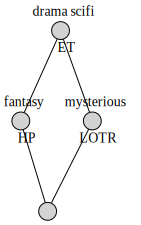

In [5]:
context.lattice.graphviz()

In [6]:
for extent, intent in context.lattice:
    print("{} - {}".format(extent, intent))

() - ('drama', 'scifi', 'fantasy', 'mysterious')
('HP',) - ('drama', 'scifi', 'fantasy')
('LOTR',) - ('drama', 'scifi', 'mysterious')
('ET', 'HP', 'LOTR') - ('drama', 'scifi')


#### Aquí está la función en cuestión

In [9]:
def getMoviesExplanation(recommendation, lattice):
    """
        Devuelve la lista de peliculas que comparten el nodo padre con la pelicula recomendada
    """
    
    # el nodo padre es aquel (o aquellos nodos) en el que encontramos el mayor numero de atributos para la pelicula recomendada
    # al ser el nodo mas especifico, es el nodo en el que la recomendacion se encuentra que mas atributos tiene 
    # por tanto tenemos que encontrar ese intent (el que tenga mayor numero de atributos donde se encuentra la pelicula 
    # recomendada en el extent, pero cuando esa peli recomendada no este sola) y coger todos los extent de ese nodo
    
    my_movies = list()
    
    # guardamos todos las movies con sus atributos compartidos segun el reticulo
    for extent, intent in lattice:
        my_movies.append((extent,intent)) # movies, attributes
    
    # de la lista total, nos quedamos con aquellos conjuntos de peliculas donde este la recomendacion, y donde 
    # la recomendacion no este sola, porque no tiene sentido
    my_movies_2 = [(x[0],x[1],len(x[1])) for x in my_movies if recommendation in x[0] and len(x[0]) > 1]
    
    # guardamos la lista donde haya mas atributos compartidos
    final_list = list(max(my_movies_2,key=lambda item:item[2])[0])
    
    # de la lista, eliminamos la recomendacion 
    final_list.remove(recommendation)
    
    return final_list

In [10]:
print(getMoviesExplanation('HP', context.lattice))

['ET', 'LOTR']
